In [2]:
import matplotlib.pyplot as plt
import yaml
import pandas as pd
from util.classes import PRIMARY_DEMOGRAPHICS, ETHNNICITY_CODING
import re
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2

# Results

### UniMatch Trained on UKBB
Train: 70. Validation: 10. Test: 20.

In [2]:
cfg = yaml.load(open('configs/ukbb_test_20.yaml', "r"), Loader=yaml.Loader)
df = pd.read_csv(cfg['results_path'])
print(df['patient_id'].nunique())
print(len(df))

20
416


In [3]:
print("DICE Mean: ", df['dice_mean'].mean())
print("RV Mean: ", df['dice_rv'].mean())
print("MYO Mean: ", df['dice_myo'].mean())
print("LV Mean: ", df['dice_lv'].mean())

DICE Mean:  81.58120456243978
RV Mean:  78.05129358002513
MYO Mean:  79.65056939082933
LV Mean:  87.04175071646486


In [4]:
filtered_rows = df[df['dice_mean'] < 50]
print(len(filtered_rows))

79


In [5]:
filtered_rows['slice_idx'].value_counts()

slice_idx
8     15
9     12
1     10
10     8
0      8
7      8
2      7
11     6
3      2
12     1
6      1
4      1
Name: count, dtype: int64

Most slices with low scores are either near the apex or the base where the segmentation ground truth is not meaningful for the task.

# Dataset

In [3]:
og_df = pd.read_csv('/vol/aimspace/projects/ukbb/data/tabular/ukb668815_imaging.csv')

/tmp/ipykernel_592191/2950344628.py:1: DtypeWarning: Columns (20,68,1186,1187,1188,1258,1259,1260,1552,2745,2746,2747,2748,2749,2750,2751,2752,2753,2754,2755,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794,2795,2796,2797,2856,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2885,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895,2896,2897,2898,2899,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000,3001,3002,3003,3004,3005,3006,3007,3008,3009,3010,3011,3012,3013,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3084,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3097,3098,3099,31

In [4]:
df_cols = og_df.columns
cols = []
for index, s in enumerate(df_cols):
    for k, v in PRIMARY_DEMOGRAPHICS.items():
        pattern = r'{}-(0.0)'.format(re.escape(k))
        if re.match(pattern, s):
            cols.append(s)

print(cols)

['31-0.0', '21000-0.0', '21003-0.0']


In [5]:
old_cols_new_cols = {}
for old_col in cols:
    new_col = PRIMARY_DEMOGRAPHICS[old_col.split('-')[0]]
    old_cols_new_cols[old_col] = new_col

cols.append('eid')
df = og_df[cols]
df.rename(columns=old_cols_new_cols, inplace=True)

/tmp/ipykernel_592191/1834475467.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=old_cols_new_cols, inplace=True)


### Merge

In [6]:
sa_df_eids = pd.read_csv('splits/ukbb/all.csv')
merged_df = pd.merge(df, sa_df_eids, on='eid')
len(merged_df)

46836

### Ethnicity Distribution

In [7]:
patient_count = {}
for k, v in ETHNNICITY_CODING.items():
    ethnic_group_df = merged_df[merged_df['ethnicity'].astype(str).str.startswith(k)]
    count = ethnic_group_df.shape[0]
    male = (ethnic_group_df['sex'] == 1).sum()
    female = count - male
    print(f'Coding {k} means {v} and has {count} patients, male {male}, female {female}')
    patient_count[k] = [count, male, female]

Coding 1 means White and has 45296 patients, male 21785, female 23511
Coding 3 means Asian and has 506 patients, male 322, female 184
Coding 4 means Black and has 313 patients, male 141, female 172
Coding 5 means Chinese and has 134 patients, male 51, female 83


### Sex Distribution

In [8]:
# add asian code 3 and chienese code 5 to represent asians
# groups of interest
goi_patient_count = {
    'white': patient_count['1'],
    'black': patient_count['4'],
    'asian': [sum(pair) for pair in zip(patient_count['3'], patient_count['5'])],
}
print(goi_patient_count)

{'white': [45296, 21785, 23511], 'black': [313, 141, 172], 'asian': [640, 373, 267]}


<function matplotlib.pyplot.show(close=None, block=None)>

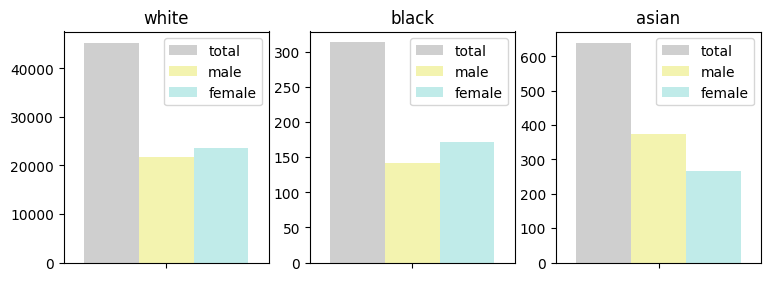

In [46]:
# plot
ctgrz = ['total', 'male', 'female']
fig, axs = plt.subplots(1, len(goi_patient_count), figsize=(9, 3))
i = 0
for grp, counts in goi_patient_count.items():
    palette = sns.color_palette("pastel")[7:]
    sns.barplot(hue=ctgrz, y=counts, ax=axs[i], palette=palette)
    axs[i].set_title(grp)
    i += 1
plt.show

### Age distribution

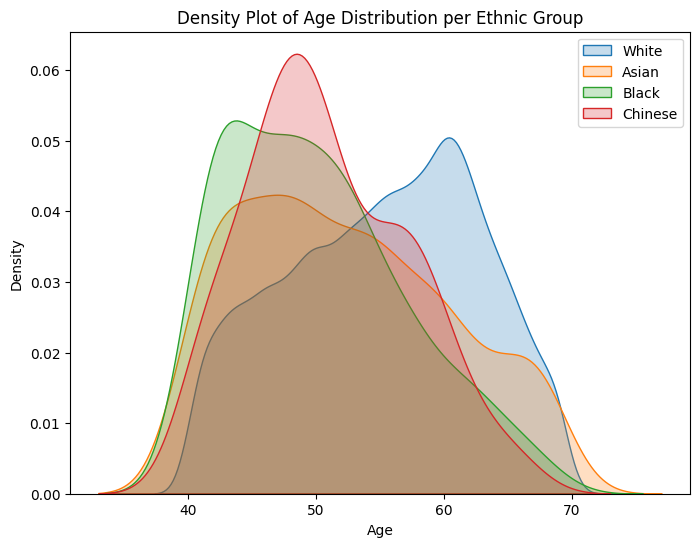

In [30]:
plt.figure(figsize=(8, 6))

for i, k in enumerate(ETHNNICITY_CODING):
    ethnic_group_df = merged_df[merged_df['ethnicity'].astype(str).str.startswith(k)]
    sns.kdeplot(ethnic_group_df['age'], label=ETHNNICITY_CODING[k], fill=True)

# Add title and labels
plt.title('Density Plot of Age Distribution per Ethnic Group')
plt.xlabel('Age')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# TODO create another dataframe with merged ethnicity (chinese, asian)

## Baseline
train on 5k

white 4k
black 313
asian 639

Train:
70%

Val:
10%

Test: 1k control for age, gender (50, 50)
white 20% test -> 800
black 20% test -> 60
asian 20% test -> 120

## Label vs Unlabeled
1%, 5%, 10% check label choice effect on the results